<a href="https://colab.research.google.com/github/Rohan-crypt/DeepLearning/blob/main/Exp9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y python3-opencv
!pip install opencv-contrib-python scikit-image scikit-learn tensorflow joblib matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core gsettings-desktop-schemas gstreamer1.0-plugins-base
  libatk-bridge2.0-0 libatk1.0-0 libatk1.0-data libatspi2.0-0 libcdparanoia0
  libcharls2 libdouble-conversion3 libexif12 libgdcm3.0 libgl2ps1.4 libglew2.2
  libgphoto2-6 libgphoto2-l10n libgphoto2-port12
  libgstreamer-plugins-base1.0-0 libgtk-3-0 libgtk-3-bin libgtk-3-common
  libilmbase25 libopencv-calib3d4.5d libopencv-contrib4.5d libopencv-core4.5d
  libopencv-dnn4.5d libopencv-features2d4.5d libopencv-flann4.5d
  libopencv-highgui4.5d libopencv-imgcodecs4.5d libopencv-imgproc4.5d
  libopencv-ml4.5d libopencv-objdetect4.5d libopencv-photo4.5d
  libopencv-shape4.5d libopencv-stitching4.5d libopencv-video4.5d
  libopencv-videoio4.5d libopencv-viz4.5d libopenexr25 liborc-0.4-0
  librsvg2-common libsocket++1 libtbb12 libtbbmalloc2 libvisual-0.4-0
  libvtk9.1 libxcomposite

In [ ]:
!wget -q https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip -qq PennFudanPed.zip

In [ ]:
import cv2
import numpy as np
import os

IMG_DIR = "/content/PennFudanPed/PNGImages/"
MASK_DIR = "/content/PennFudanPed/PedMasks/"

def get_gt_boxes(mask_path):
    mask = cv2.imread(mask_path, 0)
    boxes = []

    # Find connected pedestrian regions
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    for i in range(1, num_labels):  # skip background (0)
        x, y, w, h, area = stats[i]
        if area > 50:  # ignore tiny noise
            boxes.append((x, y, x+w, y+h))

    return boxes

In [ ]:
def get_region_proposals(image):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    return ss.process()[:1000]

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.svm import LinearSVC
import joblib

vgg = VGG16(weights="imagenet", include_top=False, pooling="avg")

def IoU(box1, box2):
    x1,y1,x2,y2 = box1
    a1,b1,a2,b2 = box2
    xi1, yi1 = max(x1,a1), max(y1,b1)
    xi2, yi2 = min(x2,a2), min(y2,b2)

    inter = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    area1 = (x2-x1)*(y2-y1)
    area2 = (a2-a1)*(b2-b1)
    union = area1 + area2 - inter
    return inter/union if union else 0

X, y = [], []

files = sorted(os.listdir(IMG_DIR))[:6]  # first 6 images

for f in files:
    img_path = IMG_DIR + f
    mask_path = MASK_DIR + f.replace(".png", "_mask.png")

    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gt_boxes = get_gt_boxes(mask_path)
    proposals = get_region_proposals(img)

    for (x, y1, w, h) in proposals:
        x2, y2 = x+w, y1+h

        crop = img[y1:y2, x:x2]
        if crop.size == 0:
            continue

        crop = cv2.resize(crop, (224,224))
        crop = preprocess_input(img_to_array(crop))
        feature = vgg.predict(np.expand_dims(crop, 0))[0]

        label = 0
        for gt in gt_boxes:
            if IoU(gt, (x, y1, x2, y2)) > 0.4:
                label = 1
                break

        X.append(feature)
        y.append(label)

X, y = np.array(X), np.array(y)

print("Training samples:", len(X))

clf = LinearSVC()
clf.fit(X, y)
joblib.dump(clf, "rcnn_svm.pkl")

print("🎉 R-CNN Training Completed!")

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

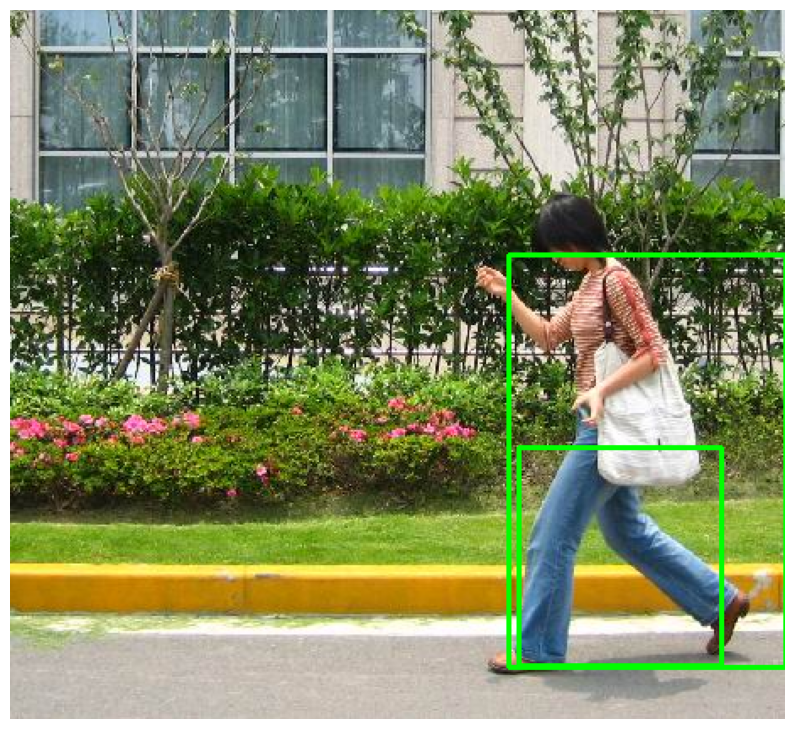

In [ ]:
import matplotlib.pyplot as plt
clf = joblib.load("rcnn_svm.pkl")

test_file = sorted(os.listdir(IMG_DIR))[10]
img = cv2.imread(IMG_DIR + test_file)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

proposals = get_region_proposals(img)

for (x,y1,w,h) in proposals[:800]:
    x2,y2 = x+w, y1+h
    crop = img[y1:y2, x:x2]

    if crop.size == 0:
        continue

    crop = cv2.resize(crop, (224,224))
    crop = preprocess_input(img_to_array(crop))
    feat = vgg.predict(np.expand_dims(crop, 0))[0]

    pred = clf.predict([feat])[0]

    if pred == 1:
        cv2.rectangle(rgb, (x,y1), (x+w, y1+h), (0,255,0), 2)

plt.figure(figsize=(10,10))
plt.imshow(rgb)
plt.axis("off")
plt.show()